<a href="https://colab.research.google.com/github/B3TA-BLOCKER/Raspberry-Pi-based-Intrusion-Detection-System/blob/main/Network_Intrusion_Detection_System_Using_LSTM_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Import Required Libraries

In [74]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Step 2: Load Dataset

In [75]:
dataset_path = "./CSE-CIC-IDS-2018"

all_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.csv')]

dataframes = [pd.read_csv(file) for file in all_files]
combined_df = pd.concat(dataframes, ignore_index=True)

combined_df.info()
combined_df.describe()
combined_df.describe(include='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56663 entries, 0 to 56662
Data columns (total 80 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Dst Port           56663 non-null  object
 1   Protocol           56663 non-null  object
 2   Timestamp          56662 non-null  object
 3   Flow Duration      56659 non-null  object
 4   Tot Fwd Pkts       56658 non-null  object
 5   Tot Bwd Pkts       56657 non-null  object
 6   TotLen Fwd Pkts    56657 non-null  object
 7   TotLen Bwd Pkts    56656 non-null  object
 8   Fwd Pkt Len Max    56656 non-null  object
 9   Fwd Pkt Len Min    56656 non-null  object
 10  Fwd Pkt Len Mean   56656 non-null  object
 11  Fwd Pkt Len Std    56656 non-null  object
 12  Bwd Pkt Len Max    56656 non-null  object
 13  Bwd Pkt Len Min    56656 non-null  object
 14  Bwd Pkt Len Mean   56656 non-null  object
 15  Bwd Pkt Len Std    56656 non-null  object
 16  Flow Byts/s        56537 non-null  objec

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,56663,56663,56662,56659.0,56658.0,56657.0,56657.0,56656.0,56656.0,56656.0,...,56655.0,56655.0,56654.0,56654.0,56654.0,56654.0,56654.0,56654.0,56654.0,56654
unique,2128,7,14967,24371.0,1923.0,287.0,3942.0,2533.0,1208.0,97.0,...,15.0,6264.0,3539.0,6091.0,6028.0,5602.0,6532.0,4658.0,6473.0,11
top,21,6,21/02/2018 02:11:14,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
freq,18242,46496,580,8221.0,19729.0,21375.0,30546.0,37739.0,30546.0,47209.0,...,22653.0,45825.0,51031.0,45825.0,45825.0,45049.0,47319.0,45049.0,45049.0,17222


# Step 3: Data Preprocessing

In [76]:
def preprocess_data(combined_df):
    columns_to_drop = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Timestamp']
    combined_df.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')

    numeric_columns = combined_df.select_dtypes(include=['number']).columns
    combined_df[numeric_columns] = combined_df[numeric_columns].fillna(combined_df[numeric_columns].median())

    categorical_cols = combined_df.select_dtypes(include=['object']).columns
    label_encoder = LabelEncoder()
    for col in categorical_cols:
        combined_df[col] = label_encoder.fit_transform(combined_df[col].astype(str))

    combined_df['Label'] = label_encoder.fit_transform(combined_df['Label'])

    print("Original Label Distribution:")
    label_counts = combined_df['Label'].value_counts()
    print(label_counts)

    X = combined_df.drop('Label', axis=1).values
    y = combined_df['Label'].values

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

    return X, y, label_counts

# Step 4: Prepare data for LSTM

In [77]:
def prepare_data_for_lstm(X, y, label_counts, min_samples=100):
    # Identify classes with sufficient samples
    valid_classes = label_counts[label_counts >= min_samples].index.tolist()

    # Filter the dataset to include only classes with sufficient samples
    mask = np.isin(y, valid_classes)
    X_filtered = X[mask]
    y_filtered = y[mask]

    print("\nFiltered Label Distribution:")
    print(np.unique(y_filtered, return_counts=True))

    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_filtered, y_filtered)

    # Convert labels to categorical
    y_resampled_cat = to_categorical(y_resampled)

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_resampled,
        y_resampled_cat,
        test_size=0.2,
        random_state=42,
        stratify=y_resampled
    )

    # Reshape for LSTM (assuming 1 timestep)
    timesteps = 1
    features = X_train.shape[1]
    X_train = X_train.reshape(X_train.shape[0], timesteps, features)
    X_test = X_test.reshape(X_test.shape[0], timesteps, features)

    return X_train, X_test, y_train, y_test

# Step 5: Create LSTM Model

In [78]:
def create_lstm_model(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(64, return_sequences=False),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Main Execution

In [79]:
def main():
    X, y, label_counts = preprocess_data(combined_df)

    X_train, X_test, y_train, y_test = prepare_data_for_lstm(X, y, label_counts)

    model = create_lstm_model((X_train.shape[1], X_train.shape[2]), y_train.shape[1])

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        'model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=25,
        batch_size=70,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Evaluate the model
    evaluation = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {evaluation[0]:.4f}")
    print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

    # Visualize training results
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Run the main function

Original Label Distribution:
Label
0     17222
1     11827
8      9334
7      8904
6      4529
4      2179
5      1730
2       611
3       230
10       87
11        9
9         1
Name: count, dtype: int64

Filtered Label Distribution:
(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([17222, 11827,   611,   230,  2179,  1730,  4529,  8904,  9334]))
Epoch 1/25
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.6847 - loss: 0.7966 - val_accuracy: 0.8787 - val_loss: 0.2429
Epoch 2/25
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8677 - loss: 0.2794 - val_accuracy: 0.8838 - val_loss: 0.2174
Epoch 3/25
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8809 - loss: 0.2501 - val_accuracy: 0.8942 - val_loss: 0.2113
Epoch 4/25
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8856 - loss: 0.2359 - val_accuracy: 0.8979 - val_loss: 0.2037
Epoch 5/25
1772/1772 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.8886 - loss: 0.2286 - val_accuracy: 0.8955 - val_loss: 0.2049
E

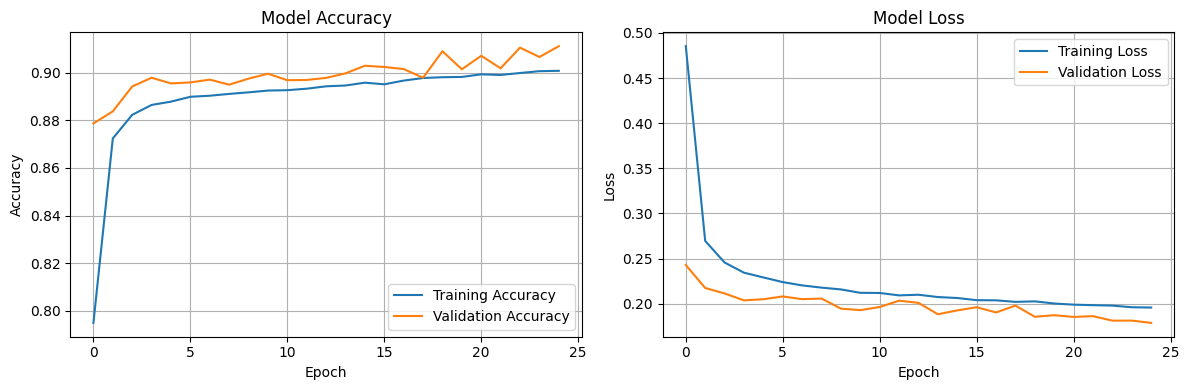

In [80]:
main()